In [7]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

from objectives import KL, Renyi, AB, det_loss
from models import VI, VI_base

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

Toy data set with noise over time

In [2]:

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()

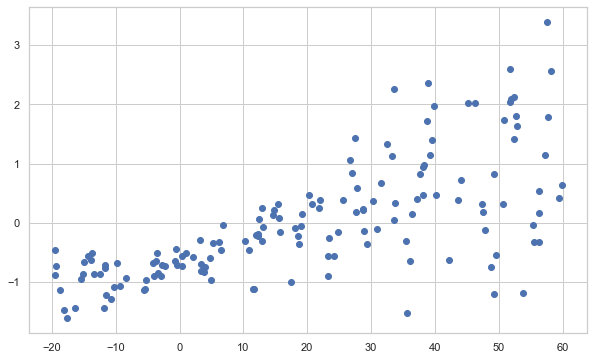

In [3]:
fig = plt.figure(figsize=[10,6])
plt.scatter(x, y)

In [4]:
# Model
X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

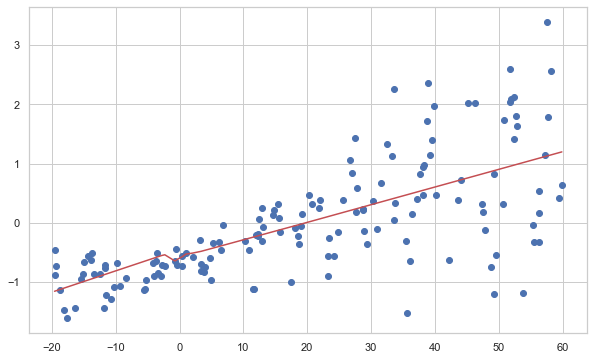

In [5]:
fig = plt.figure(figsize=[10,6])
plt.scatter(x, y)
plt.plot(x, y_pred.detach().numpy(), 'k-', color = 'r')

In [8]:
epochs = 3500

m = VI_base()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

    if epoch%500==0:
        print(loss.detach().numpy())

5.11012
1.1498638
1.2758505
1.1832958
1.2008622
1.1515684
1.2256784


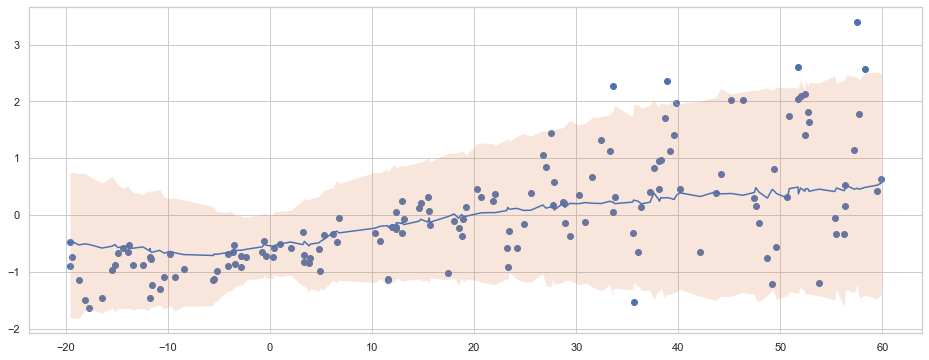

In [9]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

fig = plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)


In [24]:
epochs = 3000
m = VI_base()
optim = torch.optim.Adam(m.parameters(), lr=0.005)
c = KL()

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = -c.compute_bound(X, Y)
    loss.backward()
    optim.step()

    if epoch%500==0:
        #print(loss.detach().numpy())
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[1.55743003]] [[0.63621734]]
[[1.55743003]] [[0.63621734]]
[[1.55743003]] [[0.63621734]]
[[1.55743003]] [[0.63621734]]
[[1.55743003]] [[0.63621734]]
[[1.55743003]] [[0.63621734]]


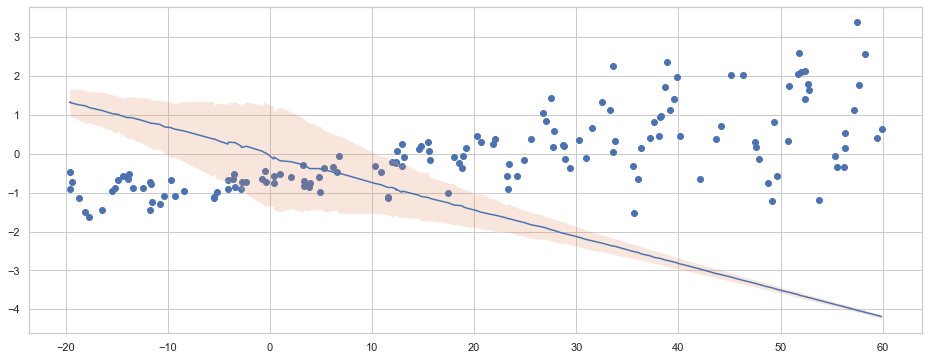

In [25]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

fig = plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)
plt.show()

In [20]:
epochs = 3000
m = VI_base()
optim = torch.optim.Adam(m.parameters(), lr=0.005)
c = Renyi(alpha=0.5)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = -c.compute_bound(X, Y)
    loss.backward()
    optim.step()

    if epoch%500==0:
        #print(loss.detach().numpy())
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[0.47001705]] [[0.39599719]]
[[0.47001705]] [[0.39599719]]
[[0.47001705]] [[0.39599719]]
[[0.47001705]] [[0.39599719]]
[[0.47001705]] [[0.39599719]]
[[0.47001705]] [[0.39599719]]


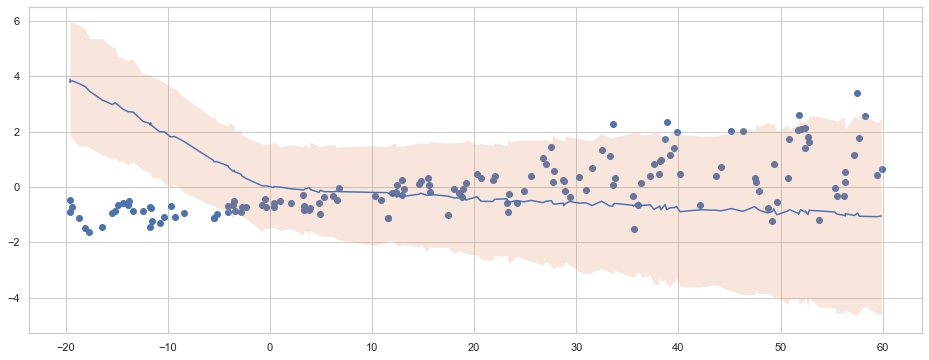

In [21]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

fig = plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)
plt.show()

In [35]:
epochs = 4000
m = VI_base()
optim = torch.optim.Adam(m.parameters(), lr=0.005)
c = AB(alpha = 0.5, beta = -1)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = -c.compute_bound(X, Y)
    loss.backward()
    optim.step()

    if epoch%500==0:
        #print(loss.detach().numpy())
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[-0.76965451]] [[0.7231168]]
[[-0.76965451]] [[0.7231168]]
[[-0.76965451]] [[0.7231168]]
[[-0.76965451]] [[0.7231168]]
[[-0.76965451]] [[0.7231168]]
[[-0.76965451]] [[0.7231168]]
[[-0.76965451]] [[0.7231168]]
[[-0.76965451]] [[0.7231168]]


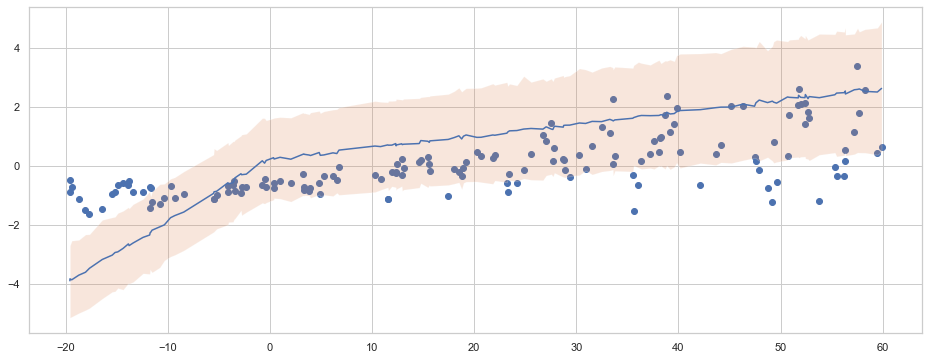

In [36]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

fig = plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)
plt.show()